# Problem Set 2

In [235]:
%%capture
# Capture suppresses output to screen
import stata_setup
stata_setup.config("/Applications/Stata 17", "be")

In [390]:
%%stata
/* Define paths for data and output */
global data "Data"
global output "Output"
global estOpt "ar2 se obslast scalar(F)"


. /* Define paths for data and output */
. global data "Data"

. global output "Output"

. global estOpt "ar2 se obslast scalar(F)"

. 


In [391]:
%%capture
%%stata
log using "$output/Econ672Ps2.log", replace

## Assignment:  Econ 672 Problem Set 2
Author: Jon Holder

## Q1 - Read in Data File

In [392]:
%%stata
use "$data/econ672_njs_data.dta", clear
describe
estpost summarize
esttab . using $output/tableQ1.tex, ///
    replace ///
    keep(sex age race esum18i bfyrearn bfeduca totch18) ///
    noobs nonumbers ///
    cells( (mean(label("Mean")) sd(label("SD")) ///
           min(label("Min")) max(label("Max")) count(label("Num Obs"))) ) ///
    coeflabels(sex "Sex" ///
              age "Age" ///
              race "Race" ///
              esum18i "Earnings 18 months later" ///
              bfyrearn "Earnings at initial survey" ///
              bfeduca "Years of educations at initial survey" ///
              totch18 "Childer under 18yr at initial survey")


. use "$data/econ672_njs_data.dta", clear

. describe

Contains data from Data/econ672_njs_data.dta
 Observations:        20,601                  
    Variables:            11                  22 Dec 2014 11:36
-------------------------------------------------------------------------------
Variable      Storage   Display    Value
    name         type    format    label      Variable label
-------------------------------------------------------------------------------
bifid           double  %7.0f                 
sex             byte    %8.0g      sexlbl     
age             byte    %4.0f                 
race            byte    %8.0g      raclbl     
esum18i         float   %9.0g                 
bfyrearn        float   %9.0g                 
ra_stat         byte    %8.0g      raslbl     
bfeduca         byte    %8.0g                 
totch18         byte    %8.0g                 
site_num        byte    %8.0g      sitlbl     
enroll          float   %9.0g                 
---------

## Q2 - Create *treatment* variable

In [393]:
%%stata
/* Create treatment =1 if in treatment group */
generate treatment =(ra_stat==1)
label variable treatment "=1 if in treatment group"

/* Drop observations that have missing earnings */
drop if esum18i==.

/* Drop treatment observations that were in control and not in JTPA */
drop if (enroll==0 & treatment==1)


. /* Create treatment =1 if in treatment group */
. generate treatment =(ra_stat==1)

. label variable treatment "=1 if in treatment group"

. 
. /* Drop observations that have missing earnings */
. drop if esum18i==.
(6,409 observations deleted)

. 
. /* Drop treatment observations that were in control and not in JTPA */
. drop if (enroll==0 & treatment==1)
(3,380 observations deleted)

. 


In [394]:
%%stata
tab treatment enroll


  =1 if in |
 treatment |        enroll
     group |         0          1 |     Total
-----------+----------------------+----------
         0 |     4,418        131 |     4,549 
         1 |         0      6,263 |     6,263 
-----------+----------------------+----------
     Total |     4,418      6,394 |    10,812 


## Q3 - Create indicators key pre-experiment info is missing.

In [395]:
%%stata
generate miss_child=(totch18==.)
label variable miss_child "=1 if no children <18 or data missing"

generate miss_educ=(bfeduca==.)
label variable miss_educ "=1 if education is 0 or data missing"

generate miss_earn=(bfyrearn==.)
label variable miss_earn "=1 if bfearn is 0 or data missing"

/* Replace missing values in main parameters with 0 */
replace totch18=0 if miss_child==1
replace bfeduca=0 if miss_educ==1
replace bfyrearn=0 if miss_earn==1


. generate miss_child=(totch18==.)

. label variable miss_child "=1 if no children <18 or data missing"

. 
. generate miss_educ=(bfeduca==.)

. label variable miss_educ "=1 if education is 0 or data missing"

. 
. generate miss_earn=(bfyrearn==.)

. label variable miss_earn "=1 if bfearn is 0 or data missing"

. 
. /* Replace missing values in main parameters with 0 */
. replace totch18=0 if miss_child==1
(967 real changes made)

. replace bfeduca=0 if miss_educ==1
(154 real changes made)

. replace bfyrearn=0 if miss_earn==1
(1,894 real changes made)

. 


In [396]:
%%stata
misstable summarize totch18 bfeduca bfyrearn

(variables nonmissing or string)


In [397]:
%%stata
misstable summarize esum18i

(variables nonmissing or string)


## Q4 - Estimate OLS experimental assignment to earnings

In [398]:
%%stata
regress esum18i treatment, robust
eststo baseOls

/* Print to log file */
esttab baseOls, ar2 se obslast scalars(F) ///
    coeflabels(treatment "In treatment group") ///
    mtitles("Earnings 18 month later")

/* Printable table for report */
esttab baseOls using $output/tableQ4.tex, ///
    replace ///
    $estOpt ///
    coeflabels(treatment "In treatment group") ///
    mtitles("Earnings 18 month later")


. regress esum18i treatment, robust

Linear regression                               Number of obs     =     10,812
                                                F(1, 10810)       =       9.32
                                                Prob > F          =     0.0023
                                                R-squared         =     0.0009
                                                Root MSE          =     9425.2

------------------------------------------------------------------------------
             |               Robust
     esum18i | Coefficient  std. err.      t    P>|t|     [95% conf. interval]
-------------+----------------------------------------------------------------
   treatment |    562.394    184.198     3.05   0.002     201.3321    923.4559
       _cons |   9274.312   141.3747    65.60   0.000     8997.191    9551.432
------------------------------------------------------------------------------

. eststo baseOls

. 
. /* Print to log file */
. esttab

## Q5 - Estimate with OLS and covariates

In [399]:
%%stata
global covariates "sex i.race age totch18 bfeduca bfyrearn i.site_num miss_child miss_educ miss_earn"

In [400]:
%%stata
regress esum18i treatment $covariates, cluster(site_num)
eststo olsCovariates


. regress esum18i treatment $covariates, cluster(site_num)

Linear regression                               Number of obs     =     10,812
                                                F(11, 15)         =          .
                                                Prob > F          =          .
                                                R-squared         =     0.1758
                                                Root MSE          =     8570.8

                              (Std. err. adjusted for 16 clusters in site_num)
------------------------------------------------------------------------------
             |               Robust
     esum18i | Coefficient  std. err.      t    P>|t|     [95% conf. interval]
-------------+----------------------------------------------------------------
   treatment |   577.7686   249.8017     2.31   0.035     45.32897    1110.208
         sex |   4186.252   244.9942    17.09   0.000     3664.059    4708.444
             |
        race |
   

In [401]:
%%stata
/* Print to log file */
esttab baseOls olsCovariates, ///
    keep(treatment) ///
    $estOpt ///
    coeflabels(treatment "In treatment group") ///
        addnotes("Estimate with covariates are clusted by site location") ///
    mtitles("Earnings 18 month later" "With covariates")

/* Printable table for report */
esttab baseOls olsCovariates using $output/tableQ5.tex, ///
    replace ///
    keep(treatment) ///
    $estOpt ///
    coeflabels(treatment "In treatment group") ///
    addnotes("Estimate with covariates are clustered by site location") ///
    mtitles("Earnings 18 month later" "With covariates")


. /* Print to log file */
. esttab baseOls olsCovariates, ///
>     keep(treatment) ///
>     $estOpt ///
>     coeflabels(treatment "In treatment group") ///
>         addnotes("Estimate with covariates are clusted by site location") ///
>     mtitles("Earnings 18 month later" "With covariates")

--------------------------------------------
                      (1)             (2)   
             Earnings 1~r    With covar~s   
--------------------------------------------
In treatme~p        562.4**         577.8*  
                  (184.2)         (249.8)   
--------------------------------------------
adj. R-sq           0.001           0.174   
F                   9.322               .   
N                   10812           10812   
--------------------------------------------
Standard errors in parentheses
Estimate with covariates are clusted by site location
* p<0.05, ** p<0.01, *** p<0.001

. 
. /* Printable table for report */
. esttab baseOls olsCovariates using $output/tab

---

## Difference-in-differences

## Q7 - Difference-in-Difference

Estimate difference between JTPA participation on earnings.  
Control group is people enrolled in JTPA and in the control group.  
Treatment group is people enrolled in JTPA and assigned to the treatment group. 

In [402]:
%%stata
generate diffEarn=esum18i-bfyrearn

In [403]:
%%stata
tabstat diffEarn, statistics(mean) by(treatment)


Summary for variables: diffEarn
Group variable: treatment (=1 if in treatment group)

treatment |      Mean
----------+----------
        0 |  6981.993
        1 |  7583.893
----------+----------
    Total |  7330.652
---------------------


In [404]:
%%stata
regress diffEarn treatment,robust
eststo didBasic


. regress diffEarn treatment,robust

Linear regression                               Number of obs     =     10,812
                                                F(1, 10810)       =      11.60
                                                Prob > F          =     0.0007
                                                R-squared         =     0.0011
                                                Root MSE          =     9057.6

------------------------------------------------------------------------------
             |               Robust
    diffEarn | Coefficient  std. err.      t    P>|t|     [95% conf. interval]
-------------+----------------------------------------------------------------
   treatment |   601.8994   176.6977     3.41   0.001     255.5394    948.2593
       _cons |   6981.993   134.9881    51.72   0.000     6717.392    7246.595
------------------------------------------------------------------------------

. eststo didBasic

. 


In [405]:
%%stata
/* DID Estimate include covariates */
regress diffEarn treatment ///
    sex i.race age totch18 bfeduca i.site_num ///
    miss_child miss_educ miss_earn, ///
    robust
eststo didCov


. /* DID Estimate include covariates */
. regress diffEarn treatment ///
>     sex i.race age totch18 bfeduca i.site_num ///
>     miss_child miss_educ miss_earn, ///
>     robust

Linear regression                               Number of obs     =     10,812
                                                F(26, 10785)      =      34.78
                                                Prob > F          =     0.0000
                                                R-squared         =     0.0851
                                                Root MSE          =     8678.4

------------------------------------------------------------------------------
             |               Robust
    diffEarn | Coefficient  std. err.      t    P>|t|     [95% conf. interval]
-------------+----------------------------------------------------------------
   treatment |   584.4146   170.4962     3.43   0.001     250.2107    918.6185
         sex |   3674.502   184.4904    19.92   0.000     3312.867    

In [406]:
%%stata
/* Table for display */
esttab didBasic didCov, ///
    keep(treatment) ///
    $estOpt ///
    mtitles("Basic" "With Covariates")
    
/* Table for output */
esttab didBasic didCov using $output/tableQ7.tex, ///
    replace ///
    keep(treatment) ///
    $estOpt ///
    mtitles("Basic Earnings" "With Covariates")


. /* Table for display */
. esttab didBasic didCov, ///
>     keep(treatment) ///
>     $estOpt ///
>     mtitles("Basic" "With Covariates")

--------------------------------------------
                      (1)             (2)   
                    Basic    With Covar~s   
--------------------------------------------
treatment           601.9***        584.4***
                  (176.7)         (170.5)   
--------------------------------------------
adj. R-sq           0.001           0.083   
F                   11.60           34.78   
N                   10812           10812   
--------------------------------------------
Standard errors in parentheses
* p<0.05, ** p<0.01, *** p<0.001

.     
. /* Table for output */
. esttab didBasic didCov using $output/tableQ7.tex, ///
>     replace ///
>     keep(treatment) ///
>     $estOpt ///
>     mtitles("Basic Earnings" "With Covariates")
(output written to Output/tableQ7.tex)

. 


---

## Regression Discontinuity

## Q9 - Drop Data from the control group with miss_earn==1

In [407]:
%%stata
/* Drop treatment group */
drop if treatment==1

/* Drop if miss_earn ==1 */
drop if miss_earn==1


. /* Drop treatment group */
. drop if treatment==1
(6,263 observations deleted)

. 
. /* Drop if miss_earn ==1 */
. drop if miss_earn==1
(792 observations deleted)

. 


## Q10 - Create rdtreat=1 for Control Group with bfyrearn<=2650

In [408]:
%%stata
generate rdtreat=(bfyrearn<=2650)

## Q11 - Construct a regression discontinuity with a window of \$500 on each side

In [409]:
%%stata
global window "bfyrearn>=2150 & bfyrearn<=3150"

In [410]:
%%stata
/* 
    Calculate differences in mean for data on each side
    of the window
*/
regress esum18i rdtreat if $window, robust
eststo rdBasic


. /* 
>     Calculate differences in mean for data on each side
>     of the window
> */
. regress esum18i rdtreat if $window, robust

Linear regression                               Number of obs     =        329
                                                F(1, 327)         =       1.37
                                                Prob > F          =     0.2428
                                                R-squared         =     0.0041
                                                Root MSE          =     8625.9

------------------------------------------------------------------------------
             |               Robust
     esum18i | Coefficient  std. err.      t    P>|t|     [95% conf. interval]
-------------+----------------------------------------------------------------
     rdtreat |   1126.426   962.5688     1.17   0.243    -767.1831    3020.034
       _cons |   9681.168   624.7583    15.50   0.000     8452.116    10910.22
-------------------------------------

In [411]:
%%stata
/* Table for display */
esttab rdBasic, ///
    $estOpt ///
    keep(rdtreat) ///
    coeflabels(rdtreat "At or below cutoff") ///
    mtitles("Window") ///
    addnotes("Cutoff at $2,650" ///
             "Window is -/+ $500")
    
/* Table for output */
esttab rdBasic using $output/tableQ11.tex, ///
    replace ///
    $estOpt ///
    keep(rdtreat) ///
    coeflabels(rdtreat "At or below cutoff") ///
    mtitles("Window") ///
    addnotes("Cutoff at \\$2,650" ///
             "Window is -/+ \\$500")


. /* Table for display */
. esttab rdBasic, ///
>     $estOpt ///
>     keep(rdtreat) ///
>     coeflabels(rdtreat "At or below cutoff") ///
>     mtitles("Window") ///
>     addnotes("Cutoff at $2,650" ///
>              "Window is -/+ $500")

----------------------------
                      (1)   
                   Window   
----------------------------
At or belo~f       1126.4   
                  (962.6)   
----------------------------
adj. R-sq           0.001   
F                   1.369   
N                     329   
----------------------------
Standard errors in parentheses
Cutoff at $2,650
Window is -/+ $500
* p<0.05, ** p<0.01, *** p<0.001

.     
. /* Table for output */
. esttab rdBasic using $output/tableQ11.tex, ///
>     replace ///
>     $estOpt ///
>     keep(rdtreat) ///
>     coeflabels(rdtreat "At or below cutoff") ///
>     mtitles("Window") ///
>     addnotes("Cutoff at \\$2,650" ///
>              "Window is -/+ \\$500")
(output written to Output/tableQ11.


RD Plot with evenly spaced mimicking variance number of bins using spacings est
> imators.

      Cutoff c = 2650 | Left of c  Right of c        Number of obs  =        32
> 9
----------------------+----------------------        Kernel         =    Unifor
> m
        Number of obs |       133         196
   Eff. Number of obs |       133         196
  Order poly. fit (p) |         1           1
     BW poly. fit (h) |   500.000     500.000
 Number of bins scale |     1.000       1.000

Outcome: esum18i. Running variable: bfyrearn.
---------------------------------------------
                      | Left of c  Right of c
----------------------+----------------------
        Bins selected |        12          16
   Average bin length |    41.667      31.250
    Median bin length |    41.667      31.250
----------------------+----------------------
    IMSE-optimal bins |         5           6
  Mimicking Var. bins |        12          16
----------------------+----------------------
Re

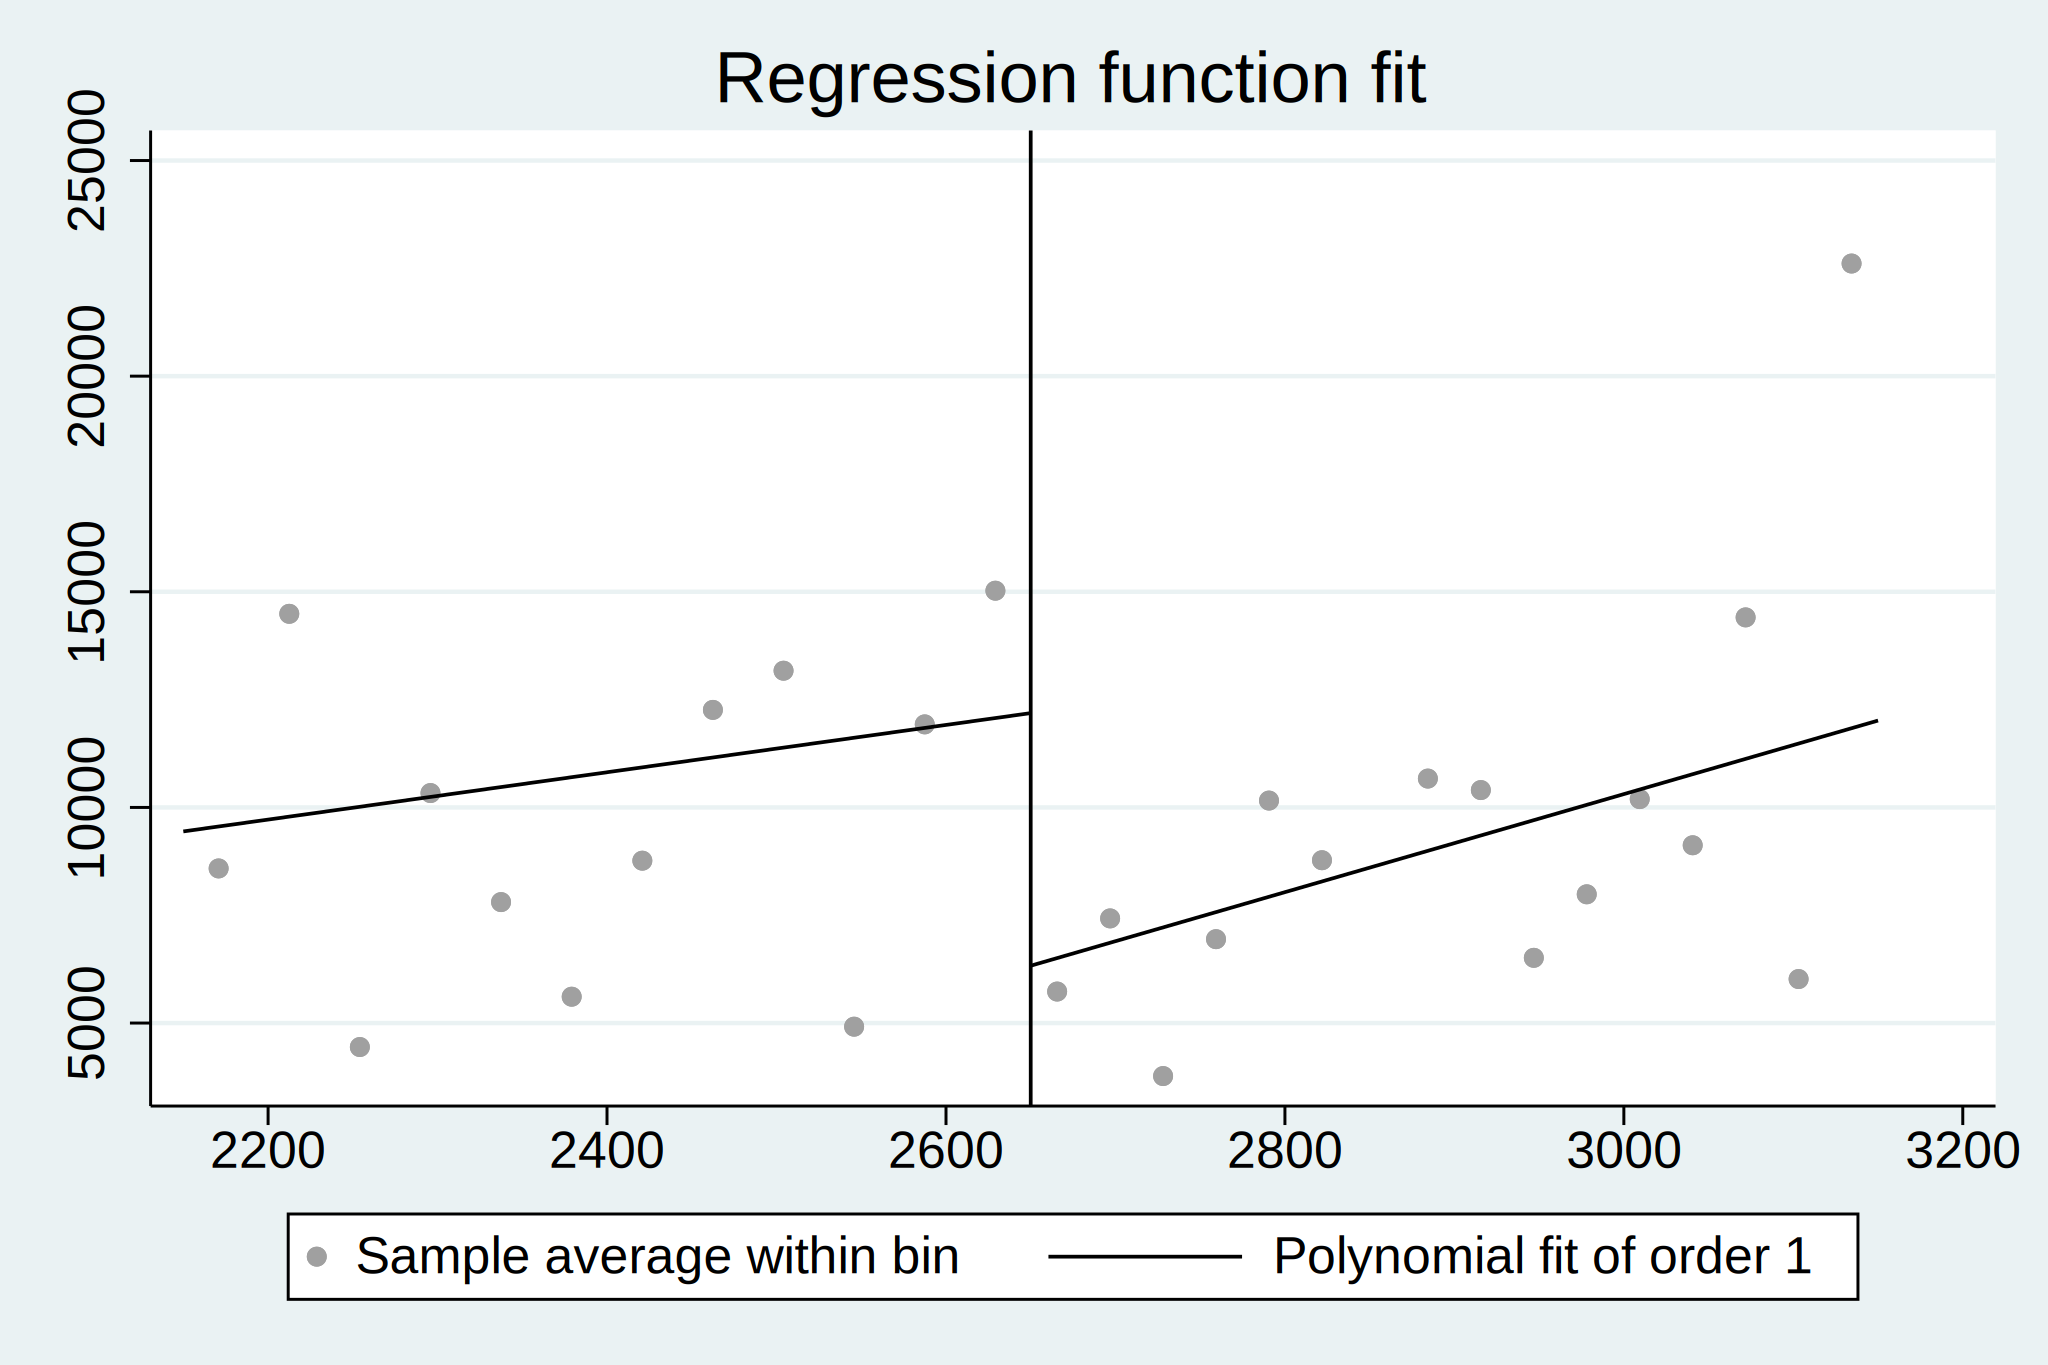

In [412]:
%%stata
rdplot esum18i bfyrearn if $window, c(2650) p(1)

## Q14 - Estimate Regression Discontinuity with OLS

In [413]:
%%stata
/* RD with all data */
regress esum18i rdtreat bfyrearn i.rdtreat#c.bfyrearn ///
    , robust
eststo rdAllData


. /* RD with all data */
. regress esum18i rdtreat bfyrearn i.rdtreat#c.bfyrearn ///
>     , robust

Linear regression                               Number of obs     =      3,757
                                                F(3, 3753)        =     154.43
                                                Prob > F          =     0.0000
                                                R-squared         =     0.1278
                                                Root MSE          =     9010.6

------------------------------------------------------------------------------
             |               Robust
     esum18i | Coefficient  std. err.      t    P>|t|     [95% conf. interval]
-------------+----------------------------------------------------------------
     rdtreat |  -3217.641   597.8045    -5.38   0.000    -4389.694   -2045.587
    bfyrearn |   .5960622   .0807892     7.38   0.000     .4376673    .7544571
             |
     rdtreat#|
  c.bfyrearn |
          1  |   1.517907 

In [414]:
%%stata
/* RD with -/+500 window */
regress esum18i rdtreat bfyrearn i.rdtreat#c.bfyrearn ///
    if $window, robust
eststo rdWindow
predict varRd, xb


. /* RD with -/+500 window */
. regress esum18i rdtreat bfyrearn i.rdtreat#c.bfyrearn ///
>     if $window, robust

Linear regression                               Number of obs     =        329
                                                F(3, 325)         =       3.73
                                                Prob > F          =     0.0117
                                                R-squared         =     0.0222
                                                Root MSE          =     8573.7

------------------------------------------------------------------------------
             |               Robust
     esum18i | Coefficient  std. err.      t    P>|t|     [95% conf. interval]
-------------+----------------------------------------------------------------
     rdtreat |   21449.47   20043.27     1.07   0.285    -17981.46    60880.39
    bfyrearn |   11.37026   4.647294     2.45   0.015     2.227683    20.51283
             |
     rdtreat#|
  c.bfyrearn |
          1


. twoway(line varRd bfyrearn if rdtreat==1) ///
>       (line varRd bfyrearn if rdtreat==0) ///
>       (scatter esum18i bfyrearn) ///
>        if $window

. 


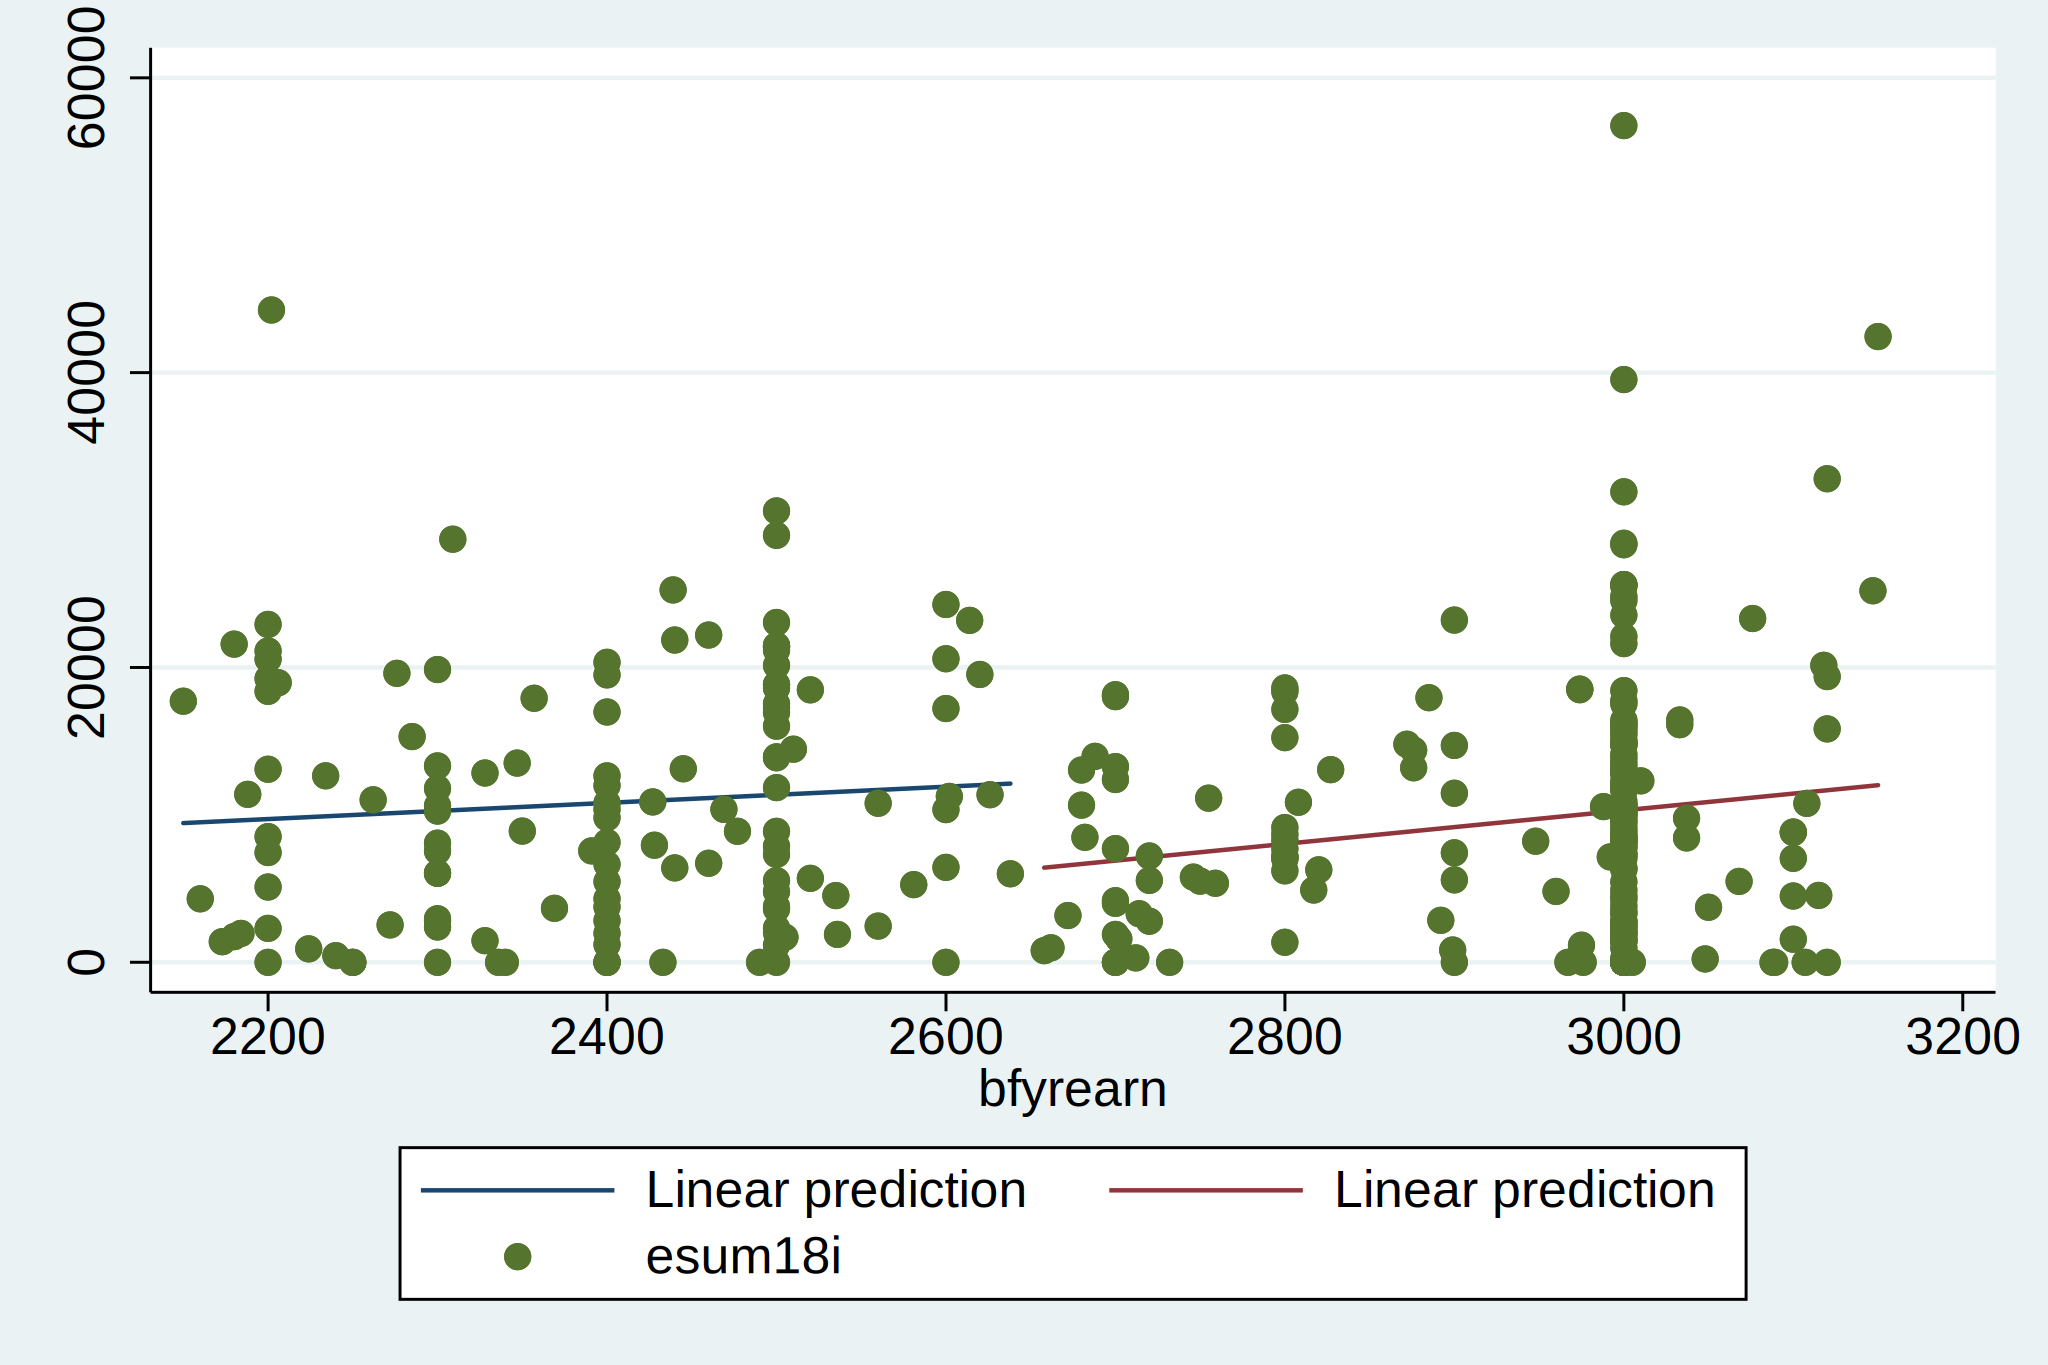

In [415]:
%%stata
twoway(line varRd bfyrearn if rdtreat==1) ///
      (line varRd bfyrearn if rdtreat==0) ///
      (scatter esum18i bfyrearn) ///
       if $window

In [416]:
%%stata
/* Table for display */
esttab rdAllData rdWindow, ///
    $estOpt ///
    keep(rdtreat bfyrearn 1.rdtreat#c.bfyrearn) ///
    coeflabels(rdtreat "At or below cutoff"  ///
               bfyrearn "Earnings 1 year prior" ///
               1.rdtreat#c.bfyrearn "\beta Interaction") ///
    mtitles("All Data" "Window") ///
    addnotes("Cutoff at $2,650" ///
             "Window is -/+ $500")
    
/* Table for output */
esttab rdAllData rdWindow using $output/tableQ14.tex, ///
    replace ///
    $estOpt ///
    keep(rdtreat bfyrearn 1.rdtreat#c.bfyrearn) ///
    coeflabels(rdtreat "At or below cutoff"  ///
               bfyrearn "Earnings 1 year prior" ///
               1.rdtreat#c.bfyrearn "$\beta\$Interaction") ///
    mtitles("All Data" "Window") ///
    addnotes("Cutoff at \\$2,650" ///
             "Window is -/+ \\$500")


. /* Table for display */
. esttab rdAllData rdWindow, ///
>     $estOpt ///
>     keep(rdtreat bfyrearn 1.rdtreat#c.bfyrearn) ///
>     coeflabels(rdtreat "At or below cutoff"  ///
>                bfyrearn "Earnings 1 year prior" ///
>                1.rdtreat#c.bfyrearn "\beta Interaction") ///
>     mtitles("All Data" "Window") ///
>     addnotes("Cutoff at $2,650" ///
>              "Window is -/+ $500")

--------------------------------------------
                      (1)             (2)   
                 All Data          Window   
--------------------------------------------
At or belo~f      -3217.6***      21449.5   
                  (597.8)       (20043.3)   

Earnings 1~r        0.596***        11.37*  
                 (0.0808)         (4.647)   

\beta Inte~n        1.518***       -5.884   
                  (0.236)         (7.711)   
--------------------------------------------
adj. R-sq           0.127           0.013   
F                   154.4           3.725  

In [417]:
%%stata
log close
clear


. log close
      name:  <unnamed>
       log:  /Users/alwashere/Documents/School Work/University of Maryland/MS A
> pplied Economics/2022 1Q Winter/ECON 672 Program Evaluation/Econ672_Winter202
> 2/ProblemSets/ProblemSet2/Output/Econ672Ps2.log
  log type:  text
 closed on:   3 Feb 2022, 15:45:24
-------------------------------------------------------------------------------

. clear

. 
